# Exploratory Statistics - Sample QC

This comes from the example notebook and the [tour of scikit-allel](http://alimanfoo.github.io/2016/06/10/scikit-allel-tour.html) blog post.

In [21]:
import numpy as np
import zarr
import pandas as pd
import dask.array as da
import allel
import scipy
from pprint import pprint

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('notebook')
%matplotlib inline

In [4]:
from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=30)
cluster

distributed.scheduler - INFO - Clear task state
/opt/conda/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)
distributed.scheduler - INFO -   Scheduler at:   tcp://10.35.63.92:39679
distributed.scheduler - INFO -   dashboard at:                    :42599


## Import the Variant Data

In [5]:
import gcsfs

gcs_bucket_fs = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='anon', access='read_only')

storage_path = 'ag1000g-release/phase2.AR1/variation/main/zarr/pass/ag1000g.phase2.ar1.pass'
store = gcsfs.mapping.GCSMap(storage_path, gcs=gcs_bucket_fs, check=False, create=False)
callset = zarr.Group(store)

In [6]:
chrom = '3L'

# All the variants
variants = allel.VariantChunkedTable(callset[chrom]['variants'], 
                                     names=['POS', 'REF', 'ALT', 'DP', 'MQ', 'QD'],
                                     index='POS')
variants

<VariantChunkedTable shape=(10640388,) dtype=[('POS', '<i4'), ('REF', 'S1'), ('ALT', 'S1', (3,)), ('DP', '<i4'), ('MQ', '<f4'), ('QD', '<f4')]
   nbytes=202.9M cbytes=-6 cratio=-35467960.0
   values=zarr.hierarchy.Group>

## Filter Variants

In [7]:
# Take a look at 003-Filter-Variants.ipyng for a more indepth look on filtering variants

def filter_variants(table, expression='(QD > 5) & (MQ > 40) & (DP > 15000) & (DP < 30000)'):
    """Filter a VariantChunkedTable based on a python expression"""
    selection = table.eval(expression)[:]
    return selection, table.compress(selection)

In [8]:
variant_selection, variants_pass = filter_variants(variants)
variants_pass

<VariantChunkedTable shape=(304050,) dtype=[('POS', '<i4'), ('REF', 'S1'), ('ALT', 'S1', (3,)), ('DP', '<i4'), ('MQ', '<f4'), ('QD', '<f4')]
   nbytes=5.8M cbytes=3.3M cratio=1.7
   values=allel.chunked.storage_zarr.ZarrTable>

In [9]:
variant_selection

array([False, False, False, ..., False, False, False])

## Subset genotypes

Let's subset the genotypes so we can more effectively look at our samples QC.

See 004-Subset-Genotypes for a more indepth explanation.

In [11]:
calldata = callset[chrom]['calldata']
# In phase 1 data this is 
# genotypes = allel.GenotypeChunkedArray(calldata['genotype'])
genotypes = allel.GenotypeChunkedArray(calldata['GT'])
genotypes

<GenotypeChunkedArray shape=(10640388, 1142, 2) dtype=int8 chunks=(524288, 61, 2)
   nbytes=22.6G cbytes=-1 cratio=-24302646192.0
   compression=blosc compression_opts={'cname': 'zstd', 'clevel': 1, 'shuffle': -1, 'blocksize': 0}
   values=zarr.core.Array>

In [13]:
!wget --no-clobber ftp://ngs.sanger.ac.uk/production/ag1000g/phase2/AR1/samples/samples.meta.txt

File ‘samples.meta.txt’ already there; not retrieving.


In [12]:
samples = pd.read_csv('samples.meta.txt', sep='\t')
sample_selection = samples.population.isin({'GHcol', 'GHgam'}).values
samples_subset = samples[sample_selection]
samples_subset.reset_index(drop=True, inplace=True)

Let’s work with two populations only for simplicity.

Now let’s subset the genotype calls to keep only variants that pass our quality filters and only samples in our two populations of interest.

In [13]:
%%time
genotypes_subset = genotypes.subset(variant_selection, sample_selection)

distributed.scheduler - INFO - Register tcp://10.35.74.2:40737
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.35.74.2:40737
distributed.core - INFO - Starting established connection


CPU times: user 1min 32s, sys: 10.3 s, total: 1min 43s
Wall time: 55.8 s


In [14]:
genotypes_subset

<GenotypeChunkedArray shape=(304050, 67, 2) dtype=int8 chunks=(4751, 67, 2)
   nbytes=38.9M cbytes=2.7M cratio=14.4
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

## Sample QC

Before we go any further, let’s do some sample QC. This is just to check if any of the samples we’re working with have major quality issues that might confound an analysis.

Compute the percent of missing and heterozygous genotype calls for each sample.

In [16]:
%%time
n_variants = len(variants_pass)
pc_missing = genotypes_subset.count_missing(axis=0)[:] * 100 / n_variants
pc_het = genotypes_subset.count_het(axis=0)[:] * 100 / n_variants

CPU times: user 997 ms, sys: 19.1 ms, total: 1.02 s
Wall time: 951 ms


## Sample QC - Missingness

In [23]:
#'GHcol', 'GHgam'

def plot_genotype_frequency(pc, title):
    """plot genotype frequencies for each sample."""
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.despine(ax=ax, offset=10)
    left = np.arange(len(pc))
    palette = sns.color_palette()
    pop2color = {'GHcol': palette[0], 'GHgam': palette[1]}
    colors = [pop2color[p] for p in samples_subset.population]
    ax.bar(left, pc, color=colors)
    ax.set_xlim(0, len(pc))
    ax.set_xlabel('Sample index')
    ax.set_ylabel('Percent calls')
    ax.set_title(title)
    handles = [mpl.patches.Patch(color=palette[0]),
               mpl.patches.Patch(color=palette[1])]
    ax.legend(handles=handles, labels=['GHcol', 'GHgam'], title='Population',
              bbox_to_anchor=(1, 1), loc='upper left')

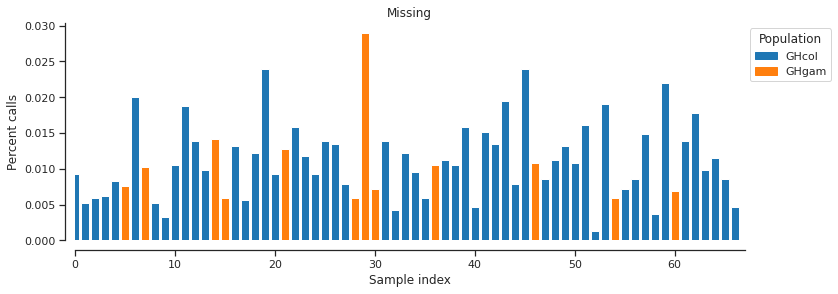

In [24]:
plot_genotype_frequency(pc_missing, 'Missing')

These all look pretty good. I think, but let's look at which one has the most missingness.

In [25]:
np.argsort(pc_missing)[-1]

29

Sample 29 has the most missingness at ~0.030%

Let’s dig a little more into this sample. Is the excess missingness spread over the whole genome, or only in a specific region? Choose two other samples to compare with.

In [27]:
g_strange = genotypes_subset.take([2, 50, 29], axis=1)
g_strange

<GenotypeChunkedArray shape=(304050, 3, 2) dtype=int8 chunks=(76013, 3, 2)
   nbytes=1.7M cbytes=185.2K cratio=9.6
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [28]:
is_missing = g_strange.is_missing()[:]
is_missing

array([[False, False, False],
       [False, False, False],
       [False, False, False],
       ...,
       [False, False, False],
       [False, False, False],
       [False, False, False]])

In [29]:
pos = variants_pass['POS'][:]
window_size = 100000
y1, windows, _ = allel.stats.windowed_statistic(pos, is_missing[:, 0], statistic=np.count_nonzero, size=window_size)
y2, windows, _ = allel.stats.windowed_statistic(pos, is_missing[:, 1], statistic=np.count_nonzero, size=window_size)
y3, windows, _ = allel.stats.windowed_statistic(pos, is_missing[:, 2], statistic=np.count_nonzero, size=window_size)
x = windows.mean(axis=1)
fig, ax = plt.subplots(figsize=(12, 4))
sns.despine(ax=ax, offset=10)
ax.plot(x, y1 * 100 / window_size, lw=1)
ax.plot(x, y2 * 100 / window_size, lw=1)
ax.plot(x, y3 * 100 / window_size, lw=1)
ax.set_xlabel('Position (bp)')
ax.set_ylabel('Percent calls');

AttributeError: module 'allel.stats' has no attribute 'windowed_statistic'

distributed.scheduler - INFO - Remove worker tcp://10.35.153.2:42541
distributed.core - INFO - Removing comms to tcp://10.35.153.2:42541


The last cell doesn't work. It should look like this:

![Missingness](http://alimanfoo.github.io/assets/2016-06-10-scikit-allel-tour_files/2016-06-10-scikit-allel-tour_98_0.png)

## Sample QC - Heterozygosity

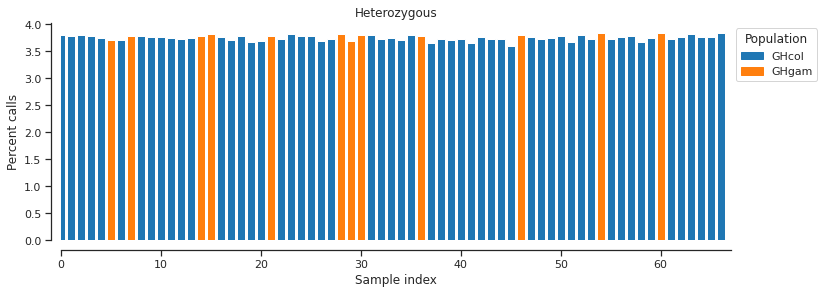

In [31]:
plot_genotype_frequency(pc_het, 'Heterozygous')

## Sample QC - Allele Count

As a first step into doing some population genetic analyses, let’s perform an allele count within each of the two populations we’ve selected. This just means, for each SNP, counting how many copies of the reference allele (0) and each of the alternate alleles (1, 2, 3) are observed.

To set this up, define a dictionary mapping population names onto the indices of samples within them.

In [32]:
#'GHcol', 'GHgam'
subpops = {
    'all': list(range(len(samples_subset))),
    'GHcol': samples_subset[samples_subset.population == 'GHcol'].index.tolist(),
    'GHgam': samples_subset[samples_subset.population == 'GHgam'].index.tolist(),
}
subpops['GHcol'][:5]

[0, 1, 2, 3, 4]

Now perform the allele count.

In [33]:
%%time
ac_subpops = genotypes_subset.count_alleles_subpops(subpops, max_allele=3)

CPU times: user 599 ms, sys: 59.8 ms, total: 659 ms
Wall time: 527 ms


In [34]:
ac_subpops

<AlleleCountsChunkedTable shape=(304050,) dtype=[('GHcol', '<i4', (4,)), ('GHgam', '<i4', (4,)), ('all', '<i4', (4,))]
   nbytes=13.9M cbytes=1.2M cratio=11.2
   values=allel.chunked.storage_zarr.ZarrTable>

In [35]:
ac_subpops['GHcol'][:5]

,0,1,2,3
0,110,0,0,0
1,110,0,0,0
2,110,0,0,0
3,110,0,0,0
4,101,9,0,0


distributed.scheduler - INFO - Remove worker tcp://10.35.158.2:45601
distributed.core - INFO - Removing comms to tcp://10.35.158.2:45601


## Sample QC - Locate segregating variants

There are lots of SNPs which do not segregate in either of these populations are so are not interesting for any analysis of these populations. We might as well get rid of them.

How many segregating SNPs are there in each population?

In [36]:
#'GHcol', 'GHgam'
for pop in 'all', 'GHcol', 'GHgam':
    print(pop, ac_subpops[pop].count_segregating())

all 105749
GHcol 89287
GHgam 55085


Locate SNPs that are segregating in the union of our two selected populations.

In [37]:
is_seg = ac_subpops['all'].is_segregating()[:]
is_seg

array([False, False, False, ..., False, False, False])

## Subset the genotypes based on segregating variants

In [40]:
genotypes_seg = genotypes_subset.compress(is_seg, axis=0)
genotypes_seg

<GenotypeChunkedArray shape=(105749, 67, 2) dtype=int8 chunks=(3305, 67, 2)
   nbytes=13.5M cbytes=2.6M cratio=5.3
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [41]:
variants_seg = variants_pass.compress(is_seg)
variants_seg

<VariantChunkedTable shape=(105749,) dtype=[('POS', '<i4'), ('REF', 'S1'), ('ALT', 'S1', (3,)), ('DP', '<i4'), ('MQ', '<f4'), ('QD', '<f4')]
   nbytes=2.0M cbytes=1.2M cratio=1.7
   values=allel.chunked.storage_zarr.ZarrTable>

In [42]:
ac_seg = ac_subpops.compress(is_seg)
ac_seg

<AlleleCountsChunkedTable shape=(105749,) dtype=[('GHcol', '<i4', (4,)), ('GHgam', '<i4', (4,)), ('all', '<i4', (4,))]
   nbytes=4.8M cbytes=745.3K cratio=6.7
   values=allel.chunked.storage_zarr.ZarrTable>

distributed.scheduler - INFO - Remove worker tcp://10.35.74.2:40737
distributed.core - INFO - Removing comms to tcp://10.35.74.2:40737
